# Evaluation with synthetic data

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_h5ad("../data/synthetic_dataset.hda5")
adata

AnnData object with n_obs × n_vars = 1000 × 99
    obs: 'transition', 'time_transition_cell', 'sim_time', 'state', 'n_counts_all', 'leiden', 'splitted_transition', 'cluster'
    var: 'n_counts', 'mean', 'std'
    uns: 'cluster_colors', 'iroot', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'splitted_transition_colors', 'state_colors', 'state_trajectory', 'transition_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
    varp: 'sA-sB', 'sB-sBmid', 'sBmid-sC', 'sBmid-sD', 'sBurn-sA', 'sC-sEndC', 'sD-sEndD'

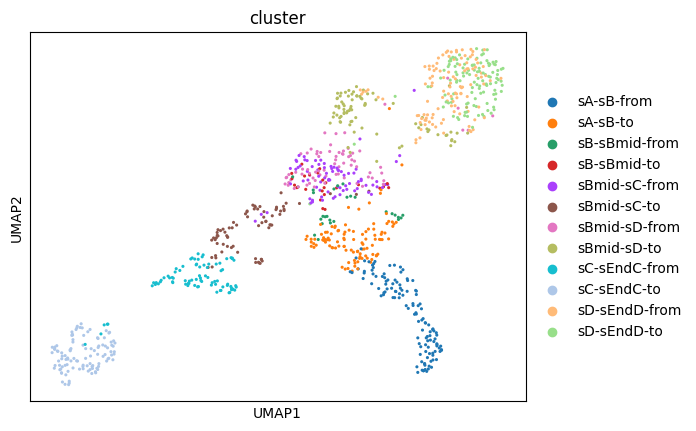

In [3]:
sc.pl.umap(adata, color="cluster", size=20)

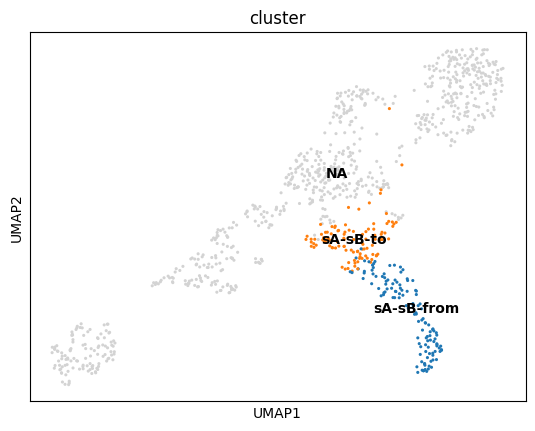

In [4]:
label_cluster_a = "sA-sB-from"
label_cluster_b = "sA-sB-to"

cluster = adata.obs["cluster"].copy()

mask_obs = adata.obs["cluster"].isin([label_cluster_a, label_cluster_b])
sc.pl.umap(adata, color="cluster", mask_obs=mask_obs, size=20, legend_loc="on data")
# the plotting overwrites clusters, so assign it back
# I do not know if this is a bug from scanpy. I cannot imagine this is wanted behavour.
adata.obs["cluster"] = cluster

In [5]:
from methods import calculate_mean_change_similarity_matrix, calculate_mmdd_similarity_matrix

similarity_metric = calculate_mean_change_similarity_matrix

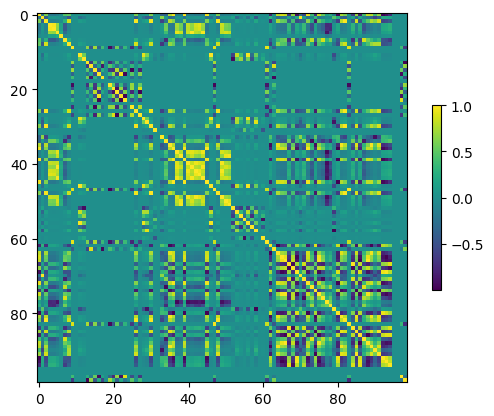

In [6]:
from data_utils import extract_samples_of_cell_cluster

df_cells = adata.to_df()
clusters = adata.obs["cluster"]
samples_cluster_a = extract_samples_of_cell_cluster(df_cells, clusters, label_cluster_a)
samples_cluster_b = extract_samples_of_cell_cluster(df_cells, clusters, label_cluster_b)

similarity_matrix = similarity_metric(samples_cluster_a, samples_cluster_b)
sc.pl.matrix(similarity_matrix)

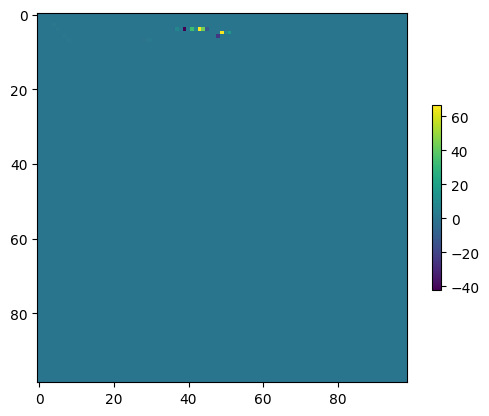

In [15]:
transition_grn = adata.varp["sA-sB"]
sc.pl.matrix(transition_grn)

In [16]:
binary_grn_mask = np.abs(transition_grn) > 0

similarity_values = similarity_matrix[binary_grn_mask]
grn_values = transition_grn[binary_grn_mask]


## Evaluation prediction of direction

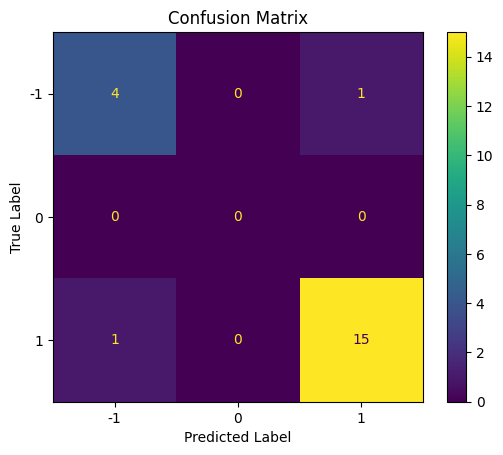

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

directions_true = np.sign(grn_values)
directions_pred = np.sign(similarity_values)

labels = [-1, 0, 1]

ConfusionMatrixDisplay.from_predictions(directions_true, directions_pred, labels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [18]:
from sklearn.metrics import balanced_accuracy_score, classification_report

score = balanced_accuracy_score(directions_true, directions_pred)
print(f"balanced accuracy score: {score}\n")

print("Classification report:\n")
print(classification_report(directions_true, directions_pred, zero_division=0.))

balanced accuracy score: 0.86875

Classification report:

              precision    recall  f1-score   support

        -1.0       0.80      0.80      0.80         5
         1.0       0.94      0.94      0.94        16

    accuracy                           0.90        21
   macro avg       0.87      0.87      0.87        21
weighted avg       0.90      0.90      0.90        21



## Evaluation ranking of weights

## Inspection if assumptions of model are violated

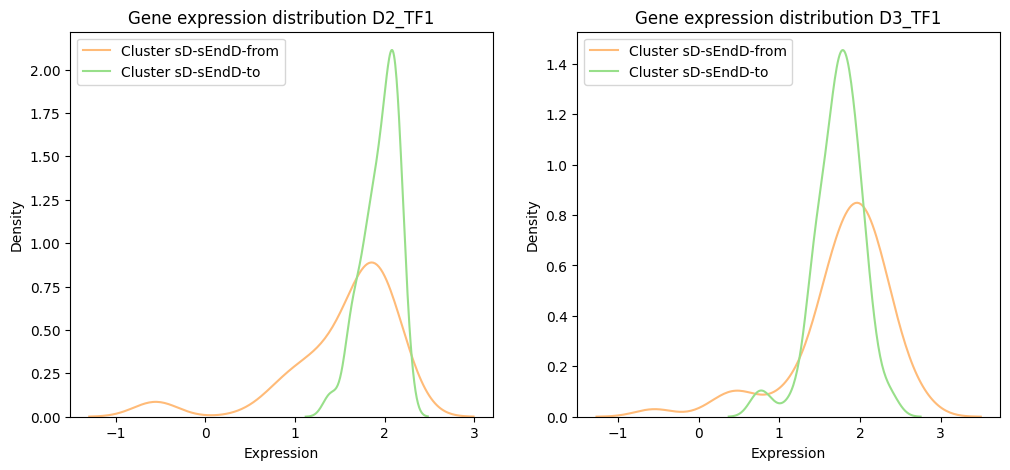

Weight: -1.0


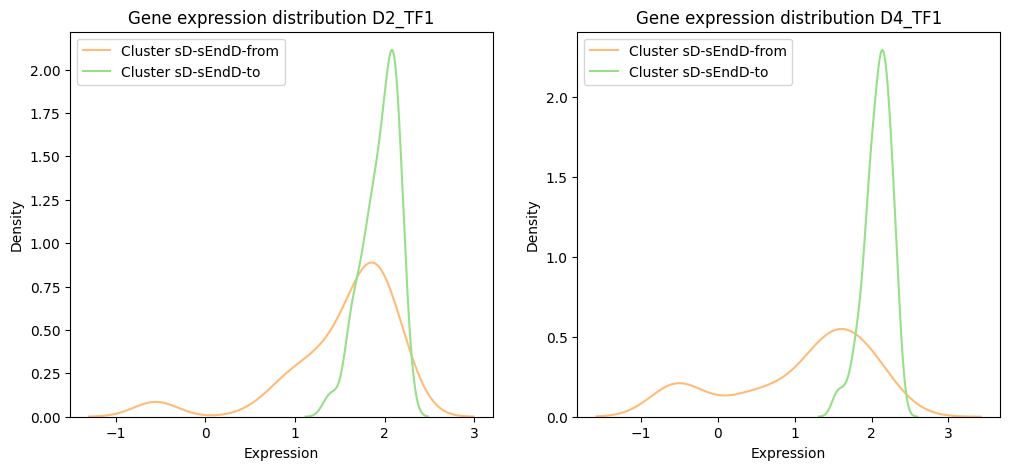

Weight: 2.0


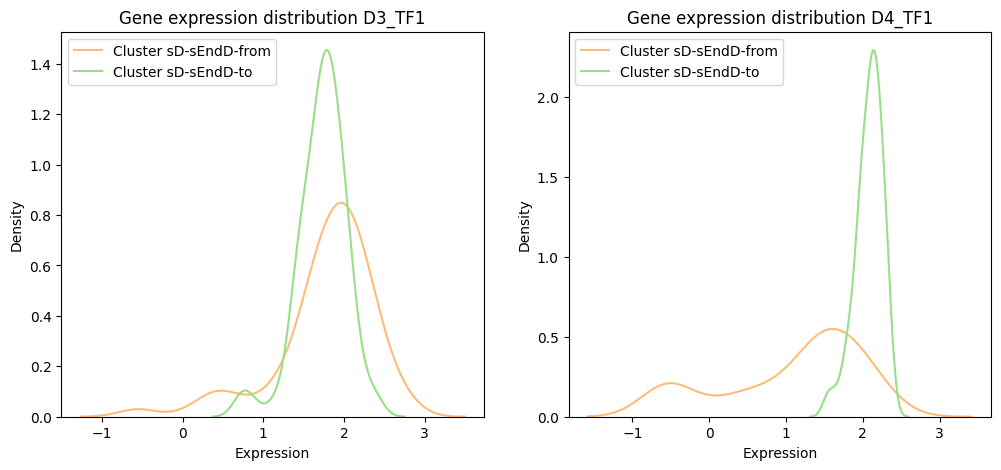

Weight: -1.0


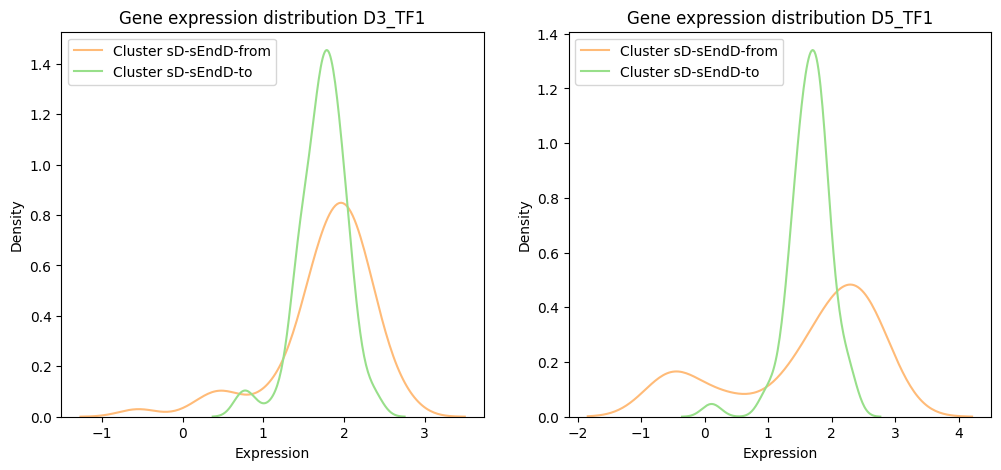

Weight: 3.0


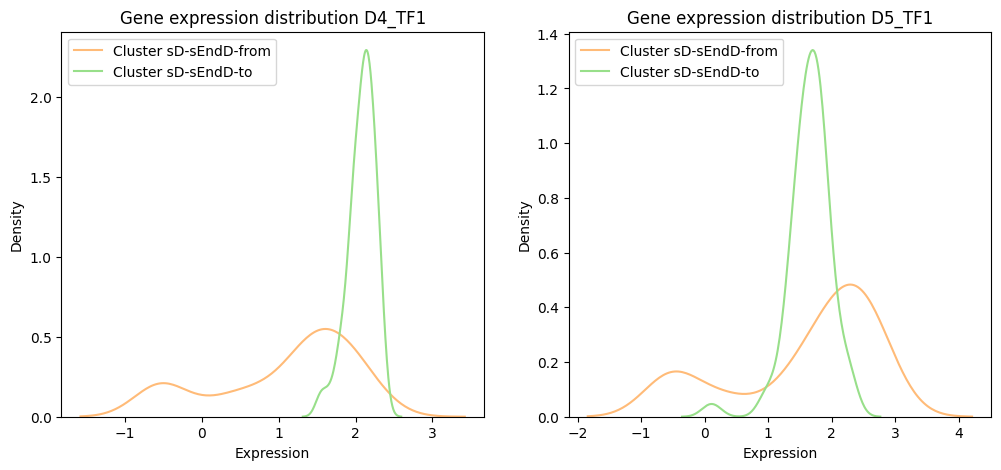

Weight: -1.0


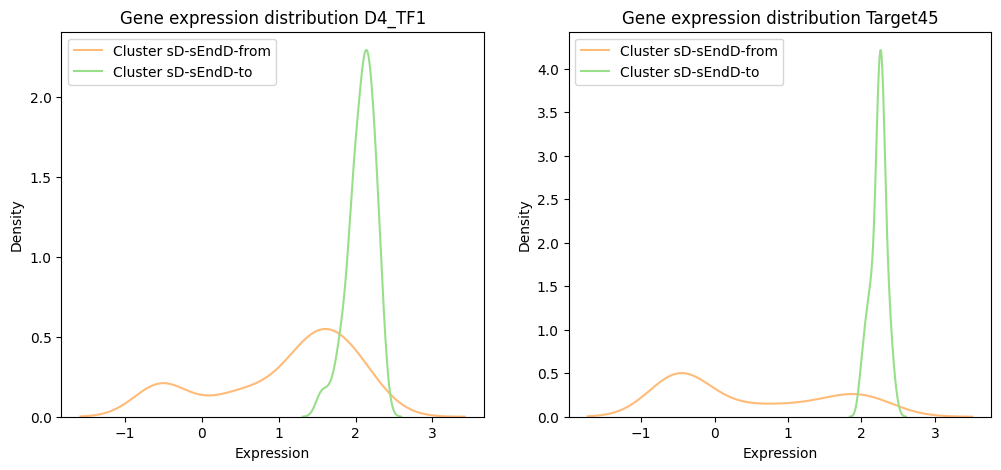

Weight: 1.989044


In [11]:
from plotting import display_gene_expression_distribution


clusters = ["sD-sEndD-from", "sD-sEndD-to"]
activated_genes = np.nonzero(transition_grn)
for driver_index, target_index in zip(*activated_genes):
    driver_gene_name = df_cells.columns[driver_index]
    target_gene_name = df_cells.columns[target_index]

    _, axes = plt.subplots(1, 2, figsize=(12, 5))
    display_gene_expression_distribution(adata, driver_gene_name, clusters=clusters, ax=axes[0])
    display_gene_expression_distribution(adata, target_gene_name, clusters=clusters, ax=axes[1])
    
    plt.show()

    weight = transition_grn[driver_index, target_index]
    print(f"Weight: {weight}")


In [12]:
df_cells = adata.to_df()
clusters = adata.obs["cluster"]

In [13]:
grouped = df_cells.groupby(clusters)
statistics = grouped.aggregate(["mean", "var"])

interesting_genes = ["A1_TF1","Target10"]
display(statistics[interesting_genes])

/tmp/ipykernel_893517/705209665.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_cells.groupby(clusters)


A1_TF1            Target10          
                   mean       var      mean       var
cluster                                              
sA-sB-from    -0.946428  6.409770 -1.113573  0.000000
sA-sB-to       0.186294  0.126086 -1.113573  0.000000
sB-sBmid-from  0.098855  0.037824 -1.113573  0.000000
sB-sBmid-to    0.062485  0.087145 -1.113573  0.000000
sBmid-sC-from  0.180686  0.085081 -1.059266  0.058405
sBmid-sC-to    0.059151  0.116628  0.118292  0.719748
sBmid-sD-from  0.139937  0.154500 -0.922202  0.266306
sBmid-sD-to    0.141179  0.117197  0.819971  0.072640
sC-sEndC-from  0.011560  0.070120  0.906168  0.002367
sC-sEndC-to   -0.015257  0.079016  0.919712  0.004430
sD-sEndD-from  0.216035  0.088608  0.958165  0.003652
sD-sEndD-to    0.253096  0.078125  0.949221  0.004070